# Wildfire Prediction Dataset (Satellite Images)

## Satellite images of areas that previously experienced wildfires in Canada

### https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset

## About Dataset

### Source

Refer to Canada's website for the original wildfires data:

*   Forest Fires - Open Government Portal
*   Original license for the data:
*   Creative Commons 4.0 Attribution (CC-BY) license – Quebec

### Dataset

This dataset contains satellite images (350x350px) in 2 classes:

*   Wildfire : 22710 images
*   No wildfire : 20140 images

The data was divided into train, test and validation with these percentages :

*   Train : ~70%
*   Test : ~15%
*   Validation : ~15%


### How
Using Longitude and Latitude coordinates for each wildfire spot (> 0.01 acres burned) found on the dataset above we extracted satellite images of those areas using MapBox API to create a more convenient format of the dataset for deep learning and building a model that can predict whether an area is at risk of a wildfire or not

### For handling files within my Google Drive space

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
# Get the current working directory
current_dir = os.getcwd()

# Print the current working directory
current_dir

'/content'

In [ ]:
# Get the path to the directory
initial_path = '/content/drive/MyDrive/06_ia/09_final_project/07_project'
dataset_path = '/dataset'

# List the contents of the directory
contents = os.listdir(initial_path + dataset_path)

# Print the contents of the directory
for item in contents:
  print(item)

valid
train
test


### Importing libraries

In [ ]:
import time
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from typing import Tuple, Dict, Any, List

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

### Working with GPU if possible

In [ ]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [ ]:
# we select to work on GPU if it is available in the machine, otherwise will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Defining the Hyper-parameters

In [ ]:
# Let's define some hyper-parameters
hparams = {
    'batch_size': 64,
    'num_epochs': 10,
    'test_batch_size': 64,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'log_interval': 100,
}

### Defining Dataset and DataLoader


#### Gathering Data

In [ ]:
initial_path

'/content/drive/MyDrive/06_ia/09_final_project/07_project'

In [ ]:
dataset_path

'/dataset'

In [ ]:
contents

['valid', 'train', 'test']

In [ ]:
# defining paths of train, validation and test data
train_path = initial_path + dataset_path + "/train"
test_path = initial_path + dataset_path + "/test"
valid_path = initial_path + dataset_path + "/valid"

print("Training data: " + train_path)
print("Test data: " + test_path)
print("Validation data: " + valid_path)

Training data: /content/drive/MyDrive/06_ia/09_final_project/07_project/dataset/train
Test data: /content/drive/MyDrive/06_ia/09_final_project/07_project/dataset/test
Validation data: /content/drive/MyDrive/06_ia/09_final_project/07_project/dataset/valid


In [ ]:
# defining image transformations
image_transforms = transforms.Compose([
    transforms.Resize((350, 350)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# loading training data using DataLoader
train_data = ImageFolder(train_path, transform=image_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams['batch_size'], shuffle=True)

In [ ]:
# loading test data using DataLoader
test_data = ImageFolder(test_path, transform=image_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=hparams['batch_size'], shuffle=False)

# loading validation data using DataLoader
val_data = ImageFolder(valid_path, transform=image_transforms)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams['batch_size'], shuffle=False)

In [ ]:
# Retrieve a sample from the dataset by simply indexing it
img, label = train_data[0]
print('Img shape: ', img.shape)
print('Label: ', label)

Img shape:  torch.Size([3, 350, 350])
Label:  0


In [ ]:
# Sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} images \
({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width \
pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Batch Img shape:  torch.Size([64, 3, 350, 350])
Batch Label shape:  torch.Size([64])
Batch Img shape:  torch.Size([64, 3, 350, 350])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 images (3 channel, 350 height pixels, 350 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


In [ ]:
# Get the class idx + names
class_names = train_data.class_to_idx
class_names

{'nowildfire': 0, 'wildfire': 1}

In [ ]:
print("Train:")
print(f"Found {len(train_data)} images belonging to {train_data.classes} classes.")
print("Test:")
print(f"Found {len(test_data)} images belonging to {test_data.classes} classes.")
print("Val:")
print(f"Found {len(val_data)} images belonging to {val_data.classes} classes.")

Train:
Found 212 images belonging to ['nowildfire', 'wildfire'] classes.
Test:
Found 66 images belonging to ['nowildfire', 'wildfire'] classes.
Val:
Found 65 images belonging to ['nowildfire', 'wildfire'] classes.


### Trying to feed a CNN

### Defining Convolutional Block

Creating the `ConvBlock` class to properly do: `Conv2d`, `ReLU`, and `MaxPool2d`. For an input of size `3x350x350`.

In [ ]:
class ConvBlock(nn.Module):

    def __init__(
              self,
              num_inp_channels: int,
              num_out_fmaps: int,
              kernel_size: int,
              pool_size: int=2
            ) -> None:

        super().__init__()

        # In a convolutional neural network (CNN), the bias term in a convolutional layer represents
        # the initial offset applied to the output of the convolution operation. When the bias term is set to False,
        # it means that the initial offset is not added to the output.
        self.conv = nn.Conv2d(in_channels=num_inp_channels,
                              out_channels=num_out_fmaps,
                              kernel_size=(kernel_size,kernel_size),
                              bias=False)
        # Setting inplace=True for the ReLU activation function in the ConvBlock class
        # can improve performance by reducing memory usage and computational overhead.
        # When inplace=True is set, the activation function modifies the input tensor directly
        # instead of creating a new tensor. This can significantly improve performance for large inputs,
        # as it eliminates the need to allocate and copy memory for the output tensor.
        self.relu = nn.ReLU(inplace=True)
        # MaxPool2d is recommended for memory saving in CNNs as it reduces the spatial dimensions of the feature maps,
        # effectively reducing the number of parameters and computations, thereby minimizing memory consumption
        # and enabling the handling of larger input images, deeper architectures, and more efficient training and inference.
        self.maxpool = nn.MaxPool2d(kernel_size=(pool_size,pool_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool(self.relu(self.conv(x)))

In [ ]:
model = ConvBlock(
    num_inp_channels=3,
    num_out_fmaps=8,
    kernel_size=2)

# run forward pass
x = torch.randn(1, 3, 350, 350)
y = model(x)

print(f'Input shape: {x.shape}')
print(f'ConvBlock output shape: {y.shape}')

Input shape: torch.Size([1, 3, 350, 350])
ConvBlock output shape: torch.Size([1, 8, 174, 174])


### Importing Softmax activation function for the Binary Classification

In [ ]:
from torch.nn.modules.activation import Softmax

## CNNBinaryClassifier Net

In [ ]:
class CNNBinaryClassifier(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.conv1 = ConvBlock(num_inp_channels=3, num_out_fmaps=8, kernel_size=2)
        self.conv2 = ConvBlock(num_inp_channels=8, num_out_fmaps=16, kernel_size=2)
        self.conv3 = ConvBlock(num_inp_channels=16, num_out_fmaps=32, kernel_size=2)

        # Defining the fully connected layers
        self.mlp = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features=56448, out_features=2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=2048, out_features=300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=300, out_features=2),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        bsz, nch, height, width = x.shape
        x = torch.reshape(x, (bsz, (nch * height * width)))
        # print(x.shape) = torch.Size([1, 56448])
        y = self.mlp(x)
        return y

In [ ]:
model = CNNBinaryClassifier()
model.to(device)

CNNBinaryClassifier(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=56448, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=300, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplac

In [ ]:
# Forward a toy example emulating the image size
bnet_classifier = CNNBinaryClassifier()
y = bnet_classifier(torch.randn(1, 3, 350, 350)).to(device)
print(f"Output shape: {y.shape}")

Output shape: torch.Size([1, 2])


## Now it's time to train and test the model.

### compute_accuracy

In [ ]:
def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> float:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """
    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

### train_epoch

In [ ]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        optimizer: torch.optim,
        criterion: torch.nn.functional,
        log_interval: int,
        ) -> Tuple[float, float]:

    # Activate the train=True flag inside the model
    network.train()

    train_loss = []
    acc = 0.
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move input data and labels to the device
        data, target = data.to(device), target.to(device)

        # Set network gradients to 0.
        optimizer.zero_grad()

        # Forward batch of images through the network
        output = network(data)

        # Compute loss
        loss = criterion(output, target)

        # Compute backpropagation
        loss.backward()

        # Update parameters of the network
        optimizer.step()

        # Compute metrics
        acc += compute_accuracy(output, target)
        train_loss.append(loss.item())

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_acc = 100. * acc / len(train_loader.dataset)

    return np.mean(train_loss), avg_acc

### test_epoch

In [ ]:
@torch.no_grad() # decorator: avoid computing gradients
def test_epoch(
        test_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    network.eval()

    test_loss = []
    acc = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = network(data)

        # Apply the loss criterion and accumulate the loss
        test_loss.append(criterion(output, target).item())

        # compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)

    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    test_loss = np.mean(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [ ]:
import time #Añadido

In [ ]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
network = CNNBinaryClassifier()
network.to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(hparams['num_epochs']):

    #Añadido
    epoch_times = []
    start_time = time.time()

    # Compute & save the average training loss for the current epoch
    train_loss, train_acc = train_epoch(train_loader, network, optimizer, criterion, hparams["log_interval"])
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Compute & save the average test loss & accuracy for the current epoch
    test_loss, test_accuracy = test_epoch(test_loader, network)

    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

    #Añadido
    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_times.append(epoch_time)
    print(f'Epoch {epoch + 1}/{hparams["num_epochs"]} - Tiempo: {epoch_time:.2f} segundos')



Train Epoch: 0 [0/212 (0%)]	Loss: 0.694792

Test set: Average loss: 0.6902, Accuracy: 32/66 (48%)

Epoch 1/10 - Tiempo: 29.86 segundos
Train Epoch: 1 [0/212 (0%)]	Loss: 0.730618

Test set: Average loss: 0.6931, Accuracy: 32/66 (48%)

Epoch 2/10 - Tiempo: 27.49 segundos
Train Epoch: 2 [0/212 (0%)]	Loss: 0.774836

Test set: Average loss: 0.6931, Accuracy: 32/66 (48%)

Epoch 3/10 - Tiempo: 26.84 segundos
Train Epoch: 3 [0/212 (0%)]	Loss: 0.693147

Test set: Average loss: 0.6931, Accuracy: 32/66 (48%)

Epoch 4/10 - Tiempo: 27.39 segundos
Train Epoch: 4 [0/212 (0%)]	Loss: 0.693147

Test set: Average loss: 0.6931, Accuracy: 32/66 (48%)

Epoch 5/10 - Tiempo: 26.23 segundos
Train Epoch: 5 [0/212 (0%)]	Loss: 0.693147

Test set: Average loss: 0.6931, Accuracy: 32/66 (48%)

Epoch 6/10 - Tiempo: 27.22 segundos
Train Epoch: 6 [0/212 (0%)]	Loss: 0.693147

Test set: Average loss: 0.6931, Accuracy: 32/66 (48%)

Epoch 7/10 - Tiempo: 26.98 segundos
Train Epoch: 7 [0/212 (0%)]	Loss: 0.693147

Test set: A

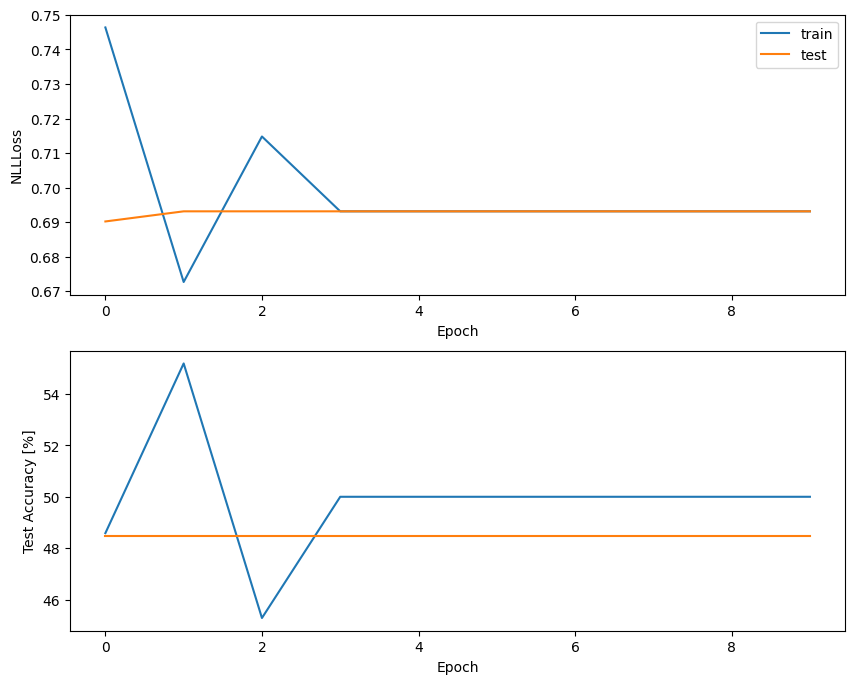

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
